In [1]:
# To have each Python cell auto-formatted
# See: https://black.readthedocs.io
%load_ext lab_black

In [2]:
! pip show kfp

Name: kfp
Version: 0.5.0
Summary: KubeFlow Pipelines SDK
Home-page: UNKNOWN
Author: google
Author-email: None
License: UNKNOWN
Location: /opt/conda/lib/python3.7/site-packages
Requires: tabulate, click, kfp-server-api, strip-hints, PyYAML, google-auth, google-cloud-storage, requests-toolbelt, Deprecated, argo-models, cloudpickle, jsonschema, kubernetes
Required-by: 


In [3]:
from typing import NamedTuple

import kfp
import kfp.components as components
import kfp.dsl as dsl
import kubeflow.fairing.utils
from kfp.components import InputPath, OutputPath, InputTextFile, OutputTextFile
from kfp.components import func_to_container_op

NAMESPACE = kubeflow.fairing.utils.get_current_k8s_namespace()

Function arguments specified with `InputPath` and `OutputPath` are the key to defining dependencies.
For now, it suffices to think of them as the input and output of each step.
How we can define dependencies is explained in the [next section](#How-to-Combine-the-Components-into-a-Pipeline).

### Component 1: Download & Prepare the Data Set

In [4]:
%%writefile minio_secret.yaml
apiVersion: v1
kind: Secret
metadata:
  name: minio-s3-secret
  annotations:
     serving.kubeflow.org/s3-endpoint: minio-service.kubeflow:9000
     serving.kubeflow.org/s3-usehttps: "0" # Default: 1. Must be 0 when testing with MinIO!
type: Opaque
data:
  awsAccessKeyID: bWluaW8=
  awsSecretAccessKey: bWluaW8xMjM=
---
apiVersion: v1
kind: ServiceAccount
metadata:
  name: default
secrets:
  - name: minio-s3-secret

Overwriting minio_secret.yaml


In [5]:
! kubectl apply -f minio_secret.yaml

secret/minio-s3-secret unchanged
serviceaccount/default configured


In [17]:
def download_and_process_dataset(data_dir: OutputPath(str)):

    import pandas as pd
    import numpy as np
    import os

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Generated training sequences for use in the model.
    def create_sequences(values, time_steps=288):
        output = []
        for i in range(len(values) - time_steps):
            output.append(values[i : (i + time_steps)])
        return np.stack(output)

    master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

    df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
    df_small_noise_url = master_url_root + df_small_noise_url_suffix
    df_small_noise = pd.read_csv(
        df_small_noise_url, parse_dates=True, index_col="timestamp"
    )

    df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
    df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
    df_daily_jumpsup = pd.read_csv(
        df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
    )

    # Normalize and save the mean and std we get,
    # for normalizing test data.
    training_mean = df_small_noise.mean()
    training_std = df_small_noise.std()
    df_training_value = (df_small_noise - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))

    x_train = create_sequences(df_training_value.values)
    print("Training input shape: ", x_train.shape)
    np.save(data_dir + "/x_train.npy", x_train)


### Component 2: Build the Model

In [30]:
def build_and_train_model(data_dir: InputPath(str), model_dir: OutputPath(str)):

    import os
    import numpy as np
    from tensorflow import keras
    from keras import layers
    import tensorflow as tf

    x_train = np.load(data_dir + "/x_train.npy")

    print("Training input shape: ", x_train.shape)

    #     TODO: make x_train into a layer so it can be used as input layer below

    class Conv1DTranspose(tf.keras.layers.Layer):
        def __init__(self, filters, kernel_size, strides=1, padding="valid"):
            super().__init__()
            self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
                filters, (kernel_size, 1), (strides, 1), padding
            )

        def call(self, x):
            x = tf.expand_dims(x, axis=2)
            x = self.conv2dtranspose(x)
            x = tf.squeeze(x, axis=2)
            return x

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2),
            layers.Dropout(rate=0.2),
            Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2),
            Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()

    history = model.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )

    model.save(model_dir)
    print(f"Model saved {model_dir}")
    print(os.listdir(model_dir))

### Combine into pipeline

In [28]:
def train_and_serve(
    data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mesosphere/kubeflow:1.0.1-0.3.1-tensorflow-2.2.0"

    downloadOp = components.func_to_container_op(
        download_and_process_dataset, base_image=BASE_IMAGE
    )()

    trainOp = components.func_to_container_op(
        build_and_train_model, base_image=BASE_IMAGE
    )(downloadOp.output)

    #     evaluateOp = components.func_to_container_op(evaluate_model, base_image=BASE_IMAGE)(
    #         downloadOp.output, trainOp.output
    #     )

    #     exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
    #         trainOp.output, evaluateOp.output, export_bucket, model_name, model_version
    #     )

    #     # Create an inference server from an external component
    #     kfserving_op = components.load_component_from_url(
    #         "https://raw.githubusercontent.com/kubeflow/pipelines/8d738ea7ddc350e9b78719910982abcd8885f93f/components/kubeflow/kfserving/component.yaml"
    #     )
    #     kfserving = kfserving_op(
    #         action="create",
    #         default_model_uri=f"s3://{export_bucket}/{model_name}",
    #         model_name="mnist",
    #         namespace=NAMESPACE,
    #         framework="tensorflow",
    #     )

    #     kfserving.after(exportOp)

    # See: https://github.com/kubeflow/kfserving/blob/master/docs/DEVELOPER_GUIDE.md#troubleshooting

In [29]:
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(name="anomaly-pipeline")
def anomaly_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    export_bucket: str = "airframe-anomaly",
    model_name: str = "airframe-anomaly",
    model_version: int = 1,
):
    train_and_serve(
        data_dir=data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)


pipeline_func = anomaly_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "airframe-anomaly-detection"

arguments = {
    "model_dir": "/train/model",
    "data_dir": "/train/data",
    #     "export_bucket": "airframe-anomaly",
    "model_name": "airframe-anomaly",
    "model_version": "1",
}

client = kfp.Client()
run_result = client.create_run_from_pipeline_func(
    pipeline_func,
    experiment_name=experiment_name,
    run_name=run_name,
    arguments=arguments,
)

### Component 3: Evaluate the Model
With the following Python function the model is evaluated.
The metrics [metadata](https://www.kubeflow.org/docs/pipelines/sdk/pipelines-metrics/) (loss and accuracy) is available to the Kubeflow Pipelines UI.
Metadata can automatically be visualized with output viewer(s).
Please go [here](https://www.kubeflow.org/docs/pipelines/sdk/output-viewer/) to see how to do that.

In [8]:
def evaluate_model(
    data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import tensorflow as tf
    import tensorflow_datasets as tfds
    from collections import namedtuple

    def normalize_test(values, mean, std):
        values -= mean
        values /= std
        return values


    df_test_value = (df_daily_jumpsup - training_mean) / training_std

    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values)
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))


    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
   

    ds_test, ds_info = tfds.load(
        "mnist",
        split="test",
        shuffle_files=True,
        as_supervised=True,
        withj_info=True,
        download=False,
        data_dir=data_dir,
    )

    # See: https://www.tensorflow.org/datasets/keras_example#build_training_pipeline
    ds_test = ds_test.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(ds_test)

    metrics = {
        "metrics": [
            {"name": "loss", "numberValue": str(loss), "format": "PERCENTAGE"},
            {"name": "accuracy", "numberValue": str(accuracy), "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))

### Component 4: Export the Model

In [9]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url="http://minio-service.kubeflow:9000",
        aws_access_key_id="minio",
        aws_secret_access_key="minio123",
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## How to Combine the Components into a Pipeline
Note that up to this point we have not yet used the Kubeflow Pipelines SDK!

With our four components (i.e. self-contained funtions) defined, we can wire up the dependencies with Kubeflow Pipelines.

The call [`components.func_to_container_op(f, base_image=img)(*args)`](https://www.kubeflow.org/docs/pipelines/sdk/sdk-overview/) has the following ingredients:
- `f` is the Python function that defines a component
- `img` is the base (Docker) image used to package the function
- `*args` lists the arguments to `f`

What the `*args` mean is best explained by going forward through the graph:
- `downloadOp` is the very first step and has no dependencies; it therefore has no `InputPath`.
  Its output (i.e. `OutputPath`) is stored in `data_dir`.
- `trainOp` needs the data downloaded from `downloadOp` and its signature lists `data_dir` (input) and `model_dir` (output).
  So, it _depends on_ `downloadOp.output` (i.e. the previous step's output) and stores its own outputs in `model_dir`, which can be used by another step.
  `downloadOp` is the parent of `trainOp`, as required.
- `evaluateOp`'s function takes three arguments: `data_dir` (i.e. `downloadOp.output`), `model_dir` (i.e. `trainOp.output`), and `metrics_path`, which is where the function stores its evaluation metrics.
  That way, `evaluateOp` can only run after the successful completion of both `downloadOp` and `trainOp`.
- `exportOp` runs the function `export_model`, which accepts five parameters: `model_dir`, `metrics`, `export_bucket`, `model_name`, and `model_version`.
  From where do we get the `model_dir`?
  It is nothing but `trainOp.output`.
  Similarly, `metrics` is `evaluateOp.output`.
  The remaining three arguments are regular Python arguments that are static for the pipeline: they do not depend on any step's output being available.
  Hence, they are defined without using `InputPath`.
  Since it is the last step of the pipeline, we also do not list any `OutputPath` for use in another step.

In [10]:
def train_and_serve(
    data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mesosphere/kubeflow:1.0.1-0.3.1-tensorflow-2.2.0"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )()

    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        downloadOp.output
    )

    evaluateOp = components.func_to_container_op(evaluate_model, base_image=BASE_IMAGE)(
        downloadOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, evaluateOp.output, export_bucket, model_name, model_version
    )

    # Create an inference server from an external component
    kfserving_op = components.load_component_from_url(
        "https://raw.githubusercontent.com/kubeflow/pipelines/8d738ea7ddc350e9b78719910982abcd8885f93f/components/kubeflow/kfserving/component.yaml"
    )
    kfserving = kfserving_op(
        action="create",
        default_model_uri=f"s3://{export_bucket}/{model_name}",
        model_name="mnist",
        namespace=NAMESPACE,
        framework="tensorflow",
    )

    kfserving.after(exportOp)

Just in case it isn't obvious: this will build the Docker images for you.
Each image is based on `BASE_IMAGE` and includes the Python functions as executable files.
Each component _can_ use a different base image though.
This may come in handy if you want to have reusable components for automatic data and/or model analysis (e.g. to investigate bias).

Note that you did not have to use [Kubeflow Fairing](../fairing/Kubeflow%20Fairing.ipynb) or `docker build` locally at all!

<div class="alert alert-block alert-info">
    Remember when we said all dependencies have to be included in the base image?
    Well, that was not quite accurate.
    It's a good idea to have everything included and tested before you define and use your pipeline components to make sure that there are not dependency conflicts.
    There is, however, a way to add <a href="https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.components.html#kfp.components.func_to_container_op">packages (<code>packages_to_install</code>) and additional code to execute <em>before</em> the function code (<code>extra_code</code>)</a>.
</div>

Is that it?
Not quite!

We still have to define the pipeline itself.
Our `train_and_serve` function defines dependencies but we must use the KFP domain-specific language (DSL) to register the pipeline with its four components:

In [11]:
# See: https://github.com/kubeflow/kfserving/blob/master/docs/DEVELOPER_GUIDE.md#troubleshooting
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End MNIST Pipeline",
    description="A sample pipeline to demonstrate multi-step model training, evaluation, export, and serving",
)
def mnist_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    export_bucket: str = "mnist",
    model_name: str = "mnist",
    model_version: int = 1,
):
    train_and_serve(
        data_dir=data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [12]:
pipeline_func = mnist_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End MNIST Pipeline"

arguments = {
    "model_dir": "/train/model",
    "data_dir": "/train/data",
    "export_bucket": "mnist",
    "model_name": "mnist",
    "model_version": "1",
}

client = kfp.Client()
run_result = client.create_run_from_pipeline_func(
    pipeline_func,
    experiment_name=experiment_name,
    run_name=run_name,
    arguments=arguments,
)

[I 200902 12:10:38 _client:267] Creating experiment End-to-End MNIST Pipeline.


The graph will look like this:

![Graph](./img/graph.png)

If there are any issues with our pipeline definition, this is where they would flare up.
So, until you submit it, you won't know if your pipeline definition is correct.

<div class="alert alert-block alert-info">
    We have so far claimed that Kubeflow Pipelines is for automation of multi-step (ad hoc) workflows and usage in CI/CD.
    You may have wondered why that is.
    After all, it is possible to set up <a href="https://www.kubeflow.org/docs/pipelines/overview/concepts/run/">recurring runs</a> of pipelines.
    The reason is that these pipeline steps are one-offs.
    Even though you can parameterize each step, including the ones that kick off an entire pipeline, there is no orchestration of workflows.
    Stated differently, if a step fails, there is no mechanism for automatic retries.
    Nor is there any support for marking success: if the step is scheduled to be run again, it will be run again, whether or not the previous execution was successful, obviating any subsequent runs (except in cases where it may be warranted).
    Kubeflow Pipelines allows <a href="https://www.kubeflow.org/docs/pipelines/reference/api/kubeflow-pipeline-api-spec/#operation--apis-v1beta1-runs--run_id--retry-post">retries</a> but it is not configurable out of the box.
    If you want Airflow- or Luigi-like behaviour for dependency management of workflows, Kubeflow Pipelines is not the tool.
</div>

## How to Predict with the Inference Server
The simplest way to check that our inference server is up and running is to check it with `curl` ( pre-installed on the cluster).

To do so, let's define a few helper functions for plotting and displaying images:

In [13]:
import matplotlib.pyplot as plt


def display_image(x_test, image_index):
    plt.imshow(x_test[image_index].reshape(28, 28), cmap="binary")


def predict_number(model, x_test, image_index):
    pred = model.predict(x_test[image_index : image_index + 1])
    print(pred.argmax())

11493376/11490434 [==============================] - 0s 0us/step


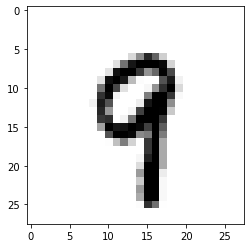

In [14]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.0  # We must transform the data in the same way as before!

image_index = 1005

display_image(x_test, image_index)

The inference server expects a JSON payload:

In [15]:
import codecs, json

tf_serving_req = {"instances": x_test[image_index : image_index + 1].tolist()}

with open("input.json", "w") as json_file:
    json.dump(tf_serving_req, json_file)

In [16]:
model = "mnist"
url = f"http://{model}-predictor-default.{NAMESPACE}.svc.cluster.local/v1/models/{model}:predict"

! curl -L $url -d@input.json

{
    "predictions": [[1.40836079e-07, 5.1750153e-06, 2.76334504e-06, 0.00259963516, 0.00124566338, 4.93358129e-06, 1.92605313e-07, 0.000128401283, 0.00166672678, 0.994346321]
    ]
}

The probabilities for each class (0-9) are shown in the `predictions` response.
The model believes the image shows a "9", which indeed it does!

For more details on the URL, please check out this [example](https://github.com/kubeflow/kfserving/tree/master/docs/samples/tensorflow#run-a-prediction).